# **Setup**

In [1]:
!pip install pmdarima

# General
from google.colab import files
from google.colab import drive
import pandas as pd
import math
import numpy as np


# Time
import datetime

DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'

# Data Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([
                     ('std_scaler', StandardScaler()),
    ])


# Machine Learning 
from sklearn.model_selection import train_test_split
from pmdarima.arima import auto_arima
import tensorflow as tf
import lightgbm as lgb
from sklearn.cluster import KMeans
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

import tensorflow as tf

# Plotting
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt


# Warning
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')

     |████████████████████████████████| 1.5MB 6.0MB/s 
     |████████████████████████████████| 9.5MB 26.5MB/s 
     |████████████████████████████████| 2.1MB 38.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
Mounted at /content/drive


# **Constants**

In [2]:
TRAIN_SAMPLE_SIZE = 20000
TEST_SAMPLE_SIZE = int(TRAIN_SAMPLE_SIZE * 0.3)

np.random.seed(42)

# **Utils**

In [3]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

In [4]:
def load_cpu_data(machine_num, train_size, test_size, log_trans, cluster, purpose):
  """Loads and processes a dataset for machine learning.

      Args:
          machine_num: An ID number of the specific machine.
          train_size: The size of the train set.
          test_size: The size of the test set.
          log_trans: A string representing the column name that need to be log transformed.


      Returns: 
          An array with ordered time seires or a pair of train set and test set arrays.
  """ 
  # Load CSV file.
  directory = 'drive/My Drive/trace-data/cluster_cpu_util.csv' 
  tags = ['Time', 'Machine_ID', 'CPU_util']
  original = pd.read_csv(directory, sep=',', names=tags).iloc[1:]
  ids = original.Machine_ID.unique()
  id = ids[machine_num]
  data = original.loc[(original.Machine_ID == id)]

  # Sort by time.
  data['Time'] = data.Time.apply(lambda x: parse_date(x[:-4]))
  data = data.sort_values(by='Time')

 
  data.fillna(method='ffill', inplace=True)
  data['CPU_util'] = data.CPU_util.apply(lambda x: pd.to_numeric(x))
  
  if(log_trans):
    data['CPU_util'] = data.CPU_util.apply(lambda x: math.log(x + 1))

  if(cluster):
    data['Time_Stamp'] = range(106305) 
    data = data[['Time_Stamp', 'CPU_util']]

  if(purpose == 'arima'):
    prepared = np.array(data)
    if(train_size == 0 and test_size == 0):
      return prepared
    train = prepared[:train_size]
    test = prepared[train_size: train_size + test_size]

    return train, test

  if(purpose == 'lgbm'):
    train = data.iloc[0:train_size, :]
    test = data.iloc[train_size: train_size + test_size, :]

    return train, test

  return data

In [5]:
def load_mem_data(machine_num, train_size, test_size, log_trans, cluster, purpose):
  """Loads and processes a dataset for machine learning.

      Args:
          machine_num: An ID number of the specific machine.
          train_size: The size of the train set.
          test_size: The size of the test set.
          log_trans: A string representing the column name that need to be log transformed.


      Returns: 
          An array with ordered time seires or a pair of train set and test set arrays.
  """ 
  # Load CSV file.
  directory = 'drive/My Drive/trace-data/cluster_mem_util.csv' 
  tags = ['Time', 'Machine_ID', 'Mem_total', 'Mem_free']
  original = pd.read_csv(directory, sep=',', names=tags).iloc[1:]
  ids = original.Machine_ID.unique()
  id = ids[machine_num]
  data = original.loc[(original.Machine_ID == id)]

  # Substract Mem_total by Mem_free to get Mem_util
  data[['Mem_total', 'Mem_free']] = data[['Mem_total', 'Mem_free']].apply(pd.to_numeric, errors='coerce')
  data.fillna(method='ffill', inplace=True)
  data.fillna(method='bfill', inplace=True)

  data['Mem_util'] = data['Mem_total'] - data['Mem_free']
  data = data.drop(['Mem_total', 'Mem_free'], axis=1)

  # Sort by time
  data['Time'] = data.Time.apply(lambda x: parse_date(x[:-4]))
  data = data.sort_values(by='Time')

  if(log_trans):
    data['Mem_util'] = data.Mem_util.apply(lambda x: math.log(x + 1))

  if(cluster):
    data['Time_Stamp'] = range(len(data)) 
    data = data[['Time_Stamp', 'Mem_util']]

  if(purpose == 'arima'):
    prepared = np.array(data)
    if(train_size == 0 and test_size == 0):
      return prepared
    train = prepared[:train_size]
    test = prepared[train_size: train_size + test_size]

    return train, test

  if(purpose == 'lgbm'):
    train = data.iloc[0:train_size, :]
    test = data.iloc[train_size: train_size + test_size, :]

    return train, test

  return data
 
  

In [6]:
def load_gpu_data(machine_num, train_size, test_size, log_trans, cluster, purpose):

  directory = 'drive/My Drive/trace-data/cluster_gpu_util.csv' 
  tags = ['Time', 'Machine_ID', 'GPU0_util', 'GPU1_util', 'GPU2_util', 'GPU3_util', 'GPU4_util', 'GPU5_util', 'GPU6_util', 'GPU7_util']
  original = pd.read_csv(directory, sep=',', names=tags, nrows=200000).iloc[1:]

  ids = original.Machine_ID.unique()
  id = ids[machine_num]
  data = original.loc[(original.Machine_ID == id)]

  data[['GPU0_util', 'GPU1_util', 'GPU2_util', 'GPU3_util', 'GPU4_util', 'GPU5_util', 'GPU6_util', 'GPU7_util']] = data[['GPU0_util', 'GPU1_util', 'GPU2_util', 'GPU3_util', 'GPU4_util', 'GPU5_util', 'GPU6_util', 'GPU7_util']].apply(pd.to_numeric, errors='coerce')
  data.fillna(0, inplace=True)  

  data['Avg_GPU_util'] = 1/8 * (data['GPU0_util'] + data['GPU1_util'] + data['GPU2_util'] + data['GPU3_util'] + data['GPU4_util'] + data['GPU5_util'] + data['GPU6_util'] + data['GPU7_util'])
  data = data.drop(['Machine_ID', 'GPU0_util', 'GPU1_util', 'GPU2_util', 'GPU3_util', 'GPU4_util', 'GPU5_util', 'GPU6_util', 'GPU7_util'], axis=1)
  data.fillna(0, inplace=True)  

  data['Time'] = data.Time.apply(lambda x: parse_date(x[:-4]))
  data = data.sort_values(by='Time')

  if(log_trans):
    data['Avg_GPU_util'] = data.Avg_GPU_util.apply(lambda x: math.log(x + 1))

  if(cluster):
    data['Time_Stamp'] = range(len(data)) 
    data = data[['Time_Stamp', 'Avg_GPU_util']]

  if(purpose == 'arima'):
    prepared = np.array(data)
    if(train_size == 0 and test_size == 0):
      return prepared
    train = prepared[:train_size]
    test = prepared[train_size: train_size + test_size]

    return train, test

  if(purpose == 'lgbm'):
    train = data.iloc[0:train_size, :]
    test = data.iloc[train_size: train_size + test_size, :]

    return train, test

  return data


In [7]:
def plot_scatter(x, y):
  plt.scatter(x, y, c=y, s=1)
  plt.xlabel("$x$", fontsize=14)
  plt.ylabel("$y$", fontsize=14, rotation=0)

In [8]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x$", fontsize=14)
    plt.ylabel("$y$", fontsize=14, rotation=0)

In [9]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [10]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
# def accuracy(y_true, y_pred):
  
#   acc = np.array((1 - np.abs((y_pred - y_true - 0.0001) / (y_true + 0.0001))) * 100)

#   for i in range(len(acc)):
#     if(acc[i] < 0):
#       acc[i] = 0
      
#   return acc

def accuracy(y_true, y_pred):
  acc = np.array((1 - np.abs((y_pred - y_true - 0.001) / (y_true + 0.001))) * 100)

  lst = []

  for element in acc:
    # if(np.isnan(element)):
    #   break

    if(element < 0):
      lst.append(0)
    else:
      lst.append(element)

  return lst

In [12]:
def cdf(x, plot=True, *args, **kwargs):
    x, y = sorted(x), np.arange(len(x)) / len(x)
    return plt.plot(x, y, *args, **kwargs) if plot else (x, y)

In [13]:
def predict(df, model, target_col, idx_cols, integer_output=True):
    """Predict target variable with a trained LightGBM model.
    
    Args: 
        df (pandas.DataFrame): Dataframe including all needed features
        model (lightgbm.Booster): Trained LightGBM booster model
        target_col (str): Name of the target column
        idx_col (list[str]): List of the names of the index columns, e.g. ["store", "brand", "week"]
        integer_output (bool): It it is True, the forecast will be rounded to an integer
        
    Returns:
        pandas.DataFrame including the predictions of the target variable 
    """
    if target_col in df.columns:
        df = df.drop(target_col, axis=1)
    predictions = pd.DataFrame({target_col: model.predict(df)})
    if integer_output:
        predictions[target_col] = predictions[target_col]#.apply(lambda x: round(x))
    return pd.concat([df[idx_cols].reset_index(drop=True), predictions], axis=1)

# **Machine Learning Utils**

In [14]:
# Window Size

def set_window(df, n, purpose=None):
  dataset = tf.data.Dataset.from_tensor_slices(df['value']).window(size=n, shift=1, stride=1, drop_remainder=True)

  lst = []

  if(purpose == 'arima'):
    for data in dataset:
      window = list(data.as_numpy_iterator())
      avg = sum(window)/len(window)
      lst.append(avg)

    group = df[n:]
    group['avg'] = lst[:-1]
    return group

  else:
    for data in dataset:
      window = list(data.as_numpy_iterator())
      lst.append(window)
    group = df[n:]
    return pd.concat([group.reset_index(drop=True), pd.DataFrame(lst[:-1]).reset_index(drop=True)], axis=1)

In [15]:
# Auto_ARIMA

def train_arima(prepared, window_size):

  params = {
        "seasonal": False,
        "start_p": 0,
        "start_q": 0,
        "max_p": 5,
        "max_q": 5,
        "m": 52,
  }

  group = set_window(prepared, window_size)
  group = group.drop(['Time_Stamp', 'cluster'], axis=1)
  log = np.log(group + 0.001)

  train_set = log.value[0: TRAIN_SAMPLE_SIZE]
  test_set = log.value[TRAIN_SAMPLE_SIZE: TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE]

  model = auto_arima(
      train_set,
      exogenous=log.drop(['value'], axis=1)[0: TRAIN_SAMPLE_SIZE],
      seasonal=params["seasonal"],
      # start_p=params["start_p"],
      # start_q=params["start_q"],
      # max_p=params["max_p"],
      # max_q=params["max_q"],
      stepwise=True,
  )

  model.fit(train_set)  

  preds = model.predict(n_periods=TEST_SAMPLE_SIZE)
  
  return accuracy(np.array(test_set), preds)


In [16]:
# LightGBM

def train_lgbm(prepared, window_size):
  group = set_window(prepared, window_size)

  train_set = group[0: TRAIN_SAMPLE_SIZE]
  test_set = group[TRAIN_SAMPLE_SIZE: TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE]
  dtrain = lgb.Dataset(train_set.drop(['value', 'cluster'], axis=1), label=train_set['value'])

  params = {
    "objective": "mape",
    "learning_rate": 0.5,
    "num_rounds": 800,
    "early_stopping_rounds": 600,
    "num_leaves": 500,
    "max_bin": 300,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
  }

  bst = lgb.train(params, dtrain, valid_sets=[dtrain], verbose_eval=50)

  # preds = predict(test_set.drop('cluster', axis=1), bst, target_col='value', idx_cols=['Time_Stamp'])
  preds = bst.predict(test_set.drop(['value', 'cluster'], axis=1))

  # return accuracy(np.array(test_set['value']), np.array(preds['value']))
  return accuracy(np.array(test_set['value']), preds)


In [17]:
# BRR

def train_brr(prepared, window_size):
  group = set_window(prepared, window_size)

  bay_ridge = BayesianRidge()
  train_set = group[0: TRAIN_SAMPLE_SIZE]
  test_set = group[TRAIN_SAMPLE_SIZE: TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE]

  X_train = pipeline.fit_transform(train_set.drop(['value', 'cluster'], axis=1))
  X_test = pipeline.fit_transform(test_set.drop(['value', 'cluster'], axis=1))

  

  # bay_ridge.fit(np.array(train_set['Time_Stamp']).reshape(-1, 1), np.array(train_set['value']))
  bay_ridge.fit(X_train, np.array(train_set['value']))

  preds = bay_ridge.predict(X_test)

  return accuracy(np.array(test_set['value']), preds)


In [18]:
# SVR

def train_svr(prepared, window_size):
  group = set_window(prepared, window_size)

  train_set = group[0: TRAIN_SAMPLE_SIZE]
  test_set = group[TRAIN_SAMPLE_SIZE: TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE]

  # X_train = pipeline.fit_transform(train_set.drop(['value', 'cluster'], axis=1))
  # X_test = pipeline.fit_transform(test_set.drop(['value', 'cluster'], axis=1))

  regressor = SVR(kernel = 'rbf')
  regressor.fit(np.array(train_set.drop(['value', 'cluster'], axis=1)), np.array(train_set['value']))
  # regressor.fit(np.array(train_set.drop(['value', 'cluster'], axis=1)), np.array(train_set['value']))

  preds = regressor.predict(test_set.drop(['value', 'cluster'], axis=1))

  return accuracy(np.array(test_set['value']), preds)

# **Clustering**

In [19]:
data = load_cpu_data(7, train_size=0, test_size=0, log_trans=False, cluster=True, purpose='arima')


In [ ]:
 data = load_mem_data(3, train_size=0, test_size=0, log_trans=False, cluster=True, purpose='arima')

In [ ]:
data = load_gpu_data(0, train_size=0, test_size=0, log_trans=False, cluster=True, purpose='arima')

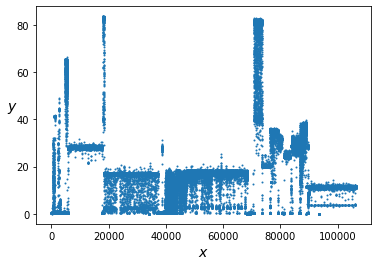

In [20]:
plt.figure()
plot_clusters(data)

plt.show()

In [21]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(data)

In [22]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

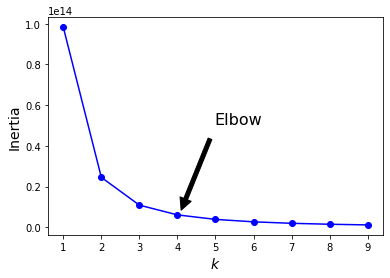

In [ ]:
plt.figure()
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[4]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.show()

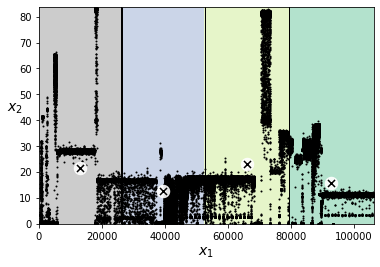

In [23]:
plt.figure()
plot_decision_boundaries(kmeans, data)

plt.show()

In [ ]:
d = {'Time_Stamp': data[:, 0], 'value': data[:, 1], 'cluster': y_pred}
df = pd.DataFrame(data=d)

In [ ]:
prepared = df[df.cluster == 2]
prepared

,Time_Stamp,value,cluster
52623,52623.0,0.0,2
52624,52624.0,0.0,2
52625,52625.0,0.0,2
52626,52626.0,0.0,2
52627,52627.0,0.0,2
...,...,...,...
79162,79162.0,0.0,2
79163,79163.0,0.0,2
79164,79164.0,0.0,2
79165,79165.0,0.0,2


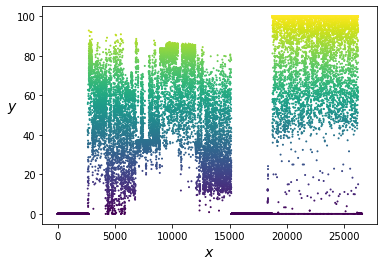

In [ ]:
plot_scatter(range(len(prepared)), prepared.value)

# **Comprehensive**

In [ ]:
arima_10 = []
arima_50 = []
arima_1 = []

In [ ]:
for i in [0, 1, 2]:
  prepared = df[df.cluster == i]

  for k in [10, 50, 1]:
    if(k == 10):
      arima_10 = np.append(train_brr(prepared, k), arima_10)
    if(k == 50):
      arima_50 = np.append(train_brr(prepared, k), arima_50)
    if(k == 1):
      arima_1 = np.append(train_brr(prepared, k), arima_1)

    print('round finished: ' + str(i) + ' - ' + str(k))

round finished: 0 - 10
round finished: 0 - 50
round finished: 0 - 1
round finished: 1 - 10
round finished: 1 - 50
round finished: 1 - 1
round finished: 2 - 10
round finished: 2 - 50
round finished: 2 - 1


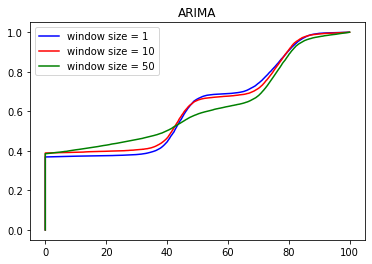

In [ ]:
plt.plot(sorted(arima_1), np.arange(len(arima_1)) / len(arima_1), label='window size = 1', color='b')
plt.plot(sorted(arima_10), np.arange(len(arima_10)) / len(arima_10), label='window size = 10', color='r')
plt.plot(sorted(arima_50), np.arange(len(arima_50)) / len(arima_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR')
plt.show()

# **ARIMA**

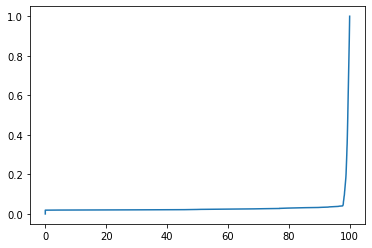

In [ ]:
arima_cpu_10_2 = train_arima(prepared, 10)
cdf(arima_cpu_10_2)

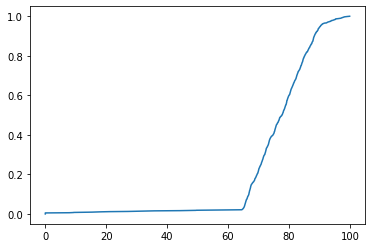

In [ ]:
arima_cpu_50_2 = train_arima(prepared, 50)
cdf(arima_cpu_50_2)

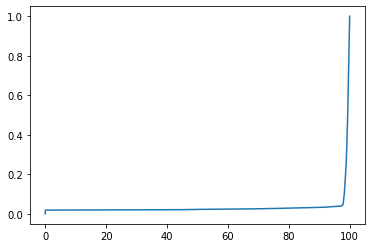

In [ ]:
arima_cpu_1_2 = train_arima(prepared, 1)
cdf(arima_cpu_1_2)

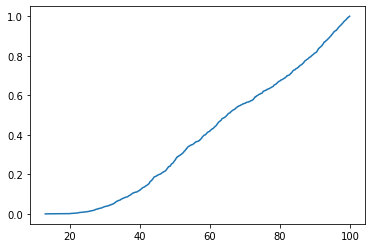

In [ ]:
arima_cpu_10_1 = train_arima(prepared, 10)
cdf(arima_cpu_10_1)

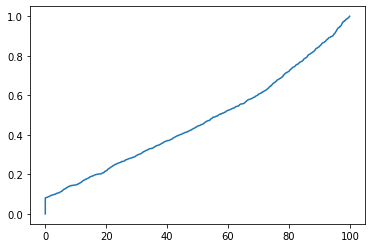

In [ ]:
arima_cpu_50_1 = train_arima(prepared, 50)
cdf(arima_cpu_50_1)

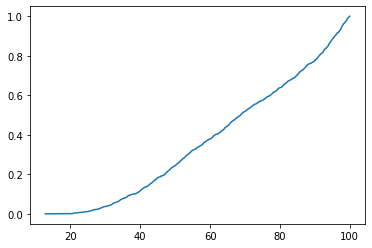

In [ ]:
arima_cpu_1_1 = train_arima(prepared, 1)
cdf(arima_cpu_1_1)

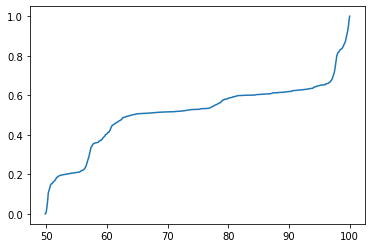

In [ ]:
arima_cpu_10_0 = train_arima(prepared, 10)
cdf(arima_cpu_10_0)

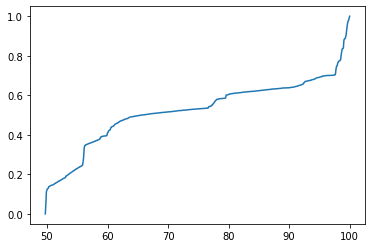

In [ ]:
arima_cpu_50_0 = train_arima(prepared, 50)
cdf(arima_cpu_50_0)

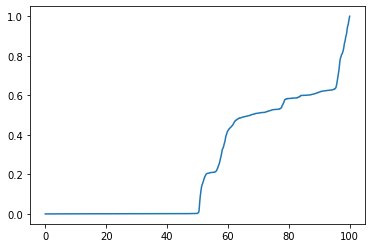

In [ ]:
arima_cpu_1_0 = train_arima(prepared, 1)
cdf(arima_cpu_1_0)

In [ ]:
arima_cpu_10 = np.append(arima_cpu_10_0, [arima_cpu_10_1, arima_cpu_10_2])
arima_cpu_50 = np.append(arima_cpu_50_0, [arima_cpu_50_1, arima_cpu_50_2])
arima_cpu_1 = np.append(arima_cpu_1_0, [arima_cpu_1_1, arima_cpu_1_2])

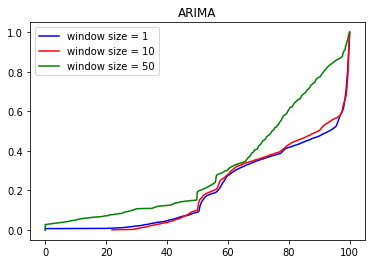

In [ ]:
plt.plot(sorted(arima_cpu_1), np.arange(len(arima_cpu_1)) / len(arima_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_cpu_10), np.arange(len(arima_cpu_10)) / len(arima_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_cpu_50), np.arange(len(arima_cpu_50)) / len(arima_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA')
plt.show()

In [ ]:
len(arima_cpu_10)

2000

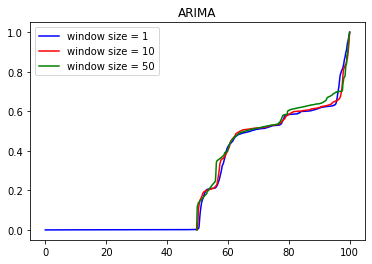

In [ ]:
plt.plot(sorted(arima_cpu_1_0), np.arange(len(arima_cpu_1_0)) / len(arima_cpu_1_0), label='window size = 1', color='b')
plt.plot(sorted(arima_cpu_10_0), np.arange(len(arima_cpu_10_0)) / len(arima_cpu_10_0), label='window size = 10', color='r')
plt.plot(sorted(arima_cpu_50_0), np.arange(len(arima_cpu_50_0)) / len(arima_cpu_50_0), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA')
plt.show()

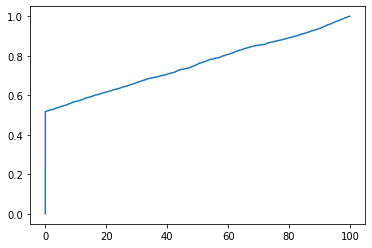

In [ ]:
arima_cpu_10 = train_arima(prepared, 10)
cdf(arima_cpu_10)

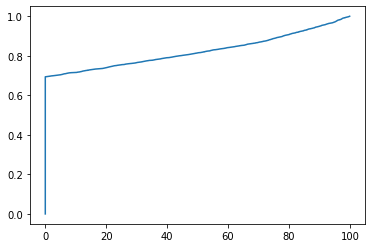

In [ ]:
arima_cpu_50 = train_arima(prepared, 50)
cdf(arima_cpu_50)

In [ ]:
arima_cpu_1 = train_arima(prepared, 1)
cdf(arima_cpu_1)

In [ ]:
plt.plot(sorted(arima_cpu_1), np.arange(len(arima_cpu_1)) / len(arima_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_cpu_10), np.arange(len(arima_cpu_10)) / len(arima_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_cpu_50), np.arange(len(arima_cpu_50)) / len(arima_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA')
plt.show()

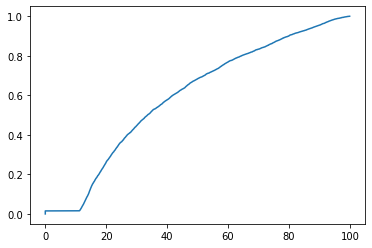

In [ ]:
arima_gpu_10 = train_arima(prepared, 10)
cdf(arima_gpu_10)

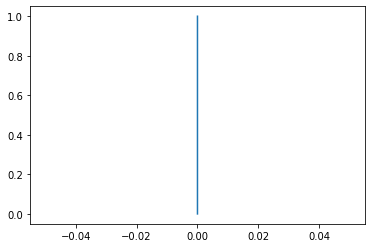

In [ ]:
arima_gpu_50 = train_arima(prepared, 50)
cdf(arima_gpu_50)

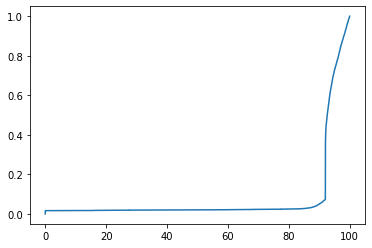

In [ ]:
arima_gpu_1 = train_arima(prepared, 1)
cdf(arima_gpu_1)

In [ ]:
arima_gpu_10 = train_arima(prepared, 10)
cdf(arima_gpu_10)

KeyboardInterrupt: ignored

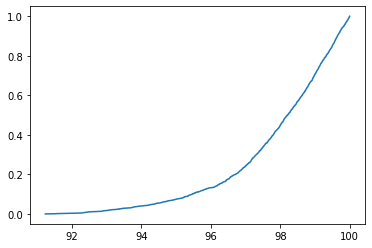

In [ ]:
arima_gpu_50 = train_arima(prepared, 50)
cdf(arima_gpu_50)

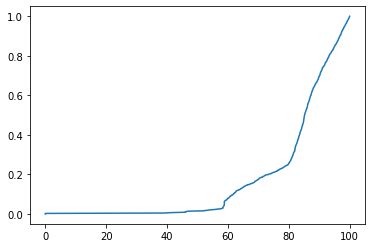

In [ ]:
arima_gpu_1 = train_arima(prepared, 1)
cdf(arima_gpu_1)

<class 'pandas.core.frame.DataFrame'>


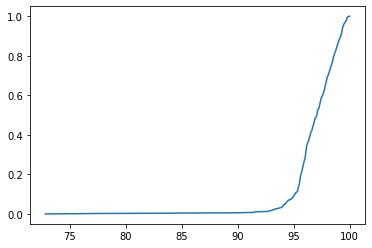

In [ ]:
arima_cpu_10 = train_arima(prepared, 10)
cdf(arima_cpu_10)

<class 'pandas.core.frame.DataFrame'>


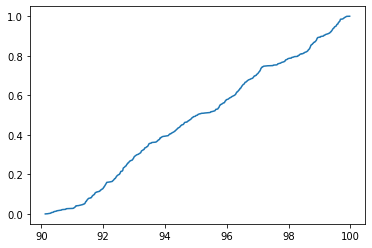

In [ ]:
arima_cpu_50 = train_arima(prepared, 50)
cdf(arima_cpu_50)

<class 'pandas.core.frame.DataFrame'>


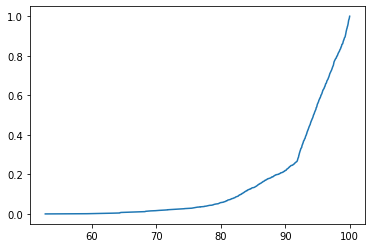

In [ ]:
arima_cpu_1 = train_arima(prepared, 1)
cdf(arima_cpu_1)

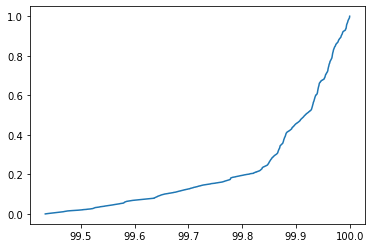

In [ ]:
arima_mem_10 = train_arima(prepared, 10)
cdf(arima_mem_10)

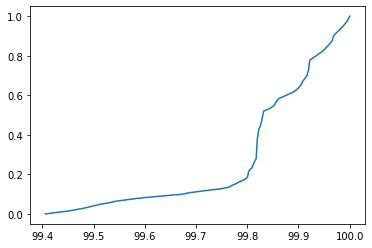

In [ ]:
arima_mem_50 = train_arima(prepared, 50)
cdf(arima_mem_50)

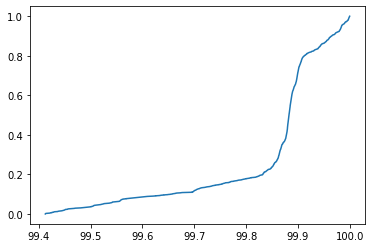

In [ ]:
arima_mem_1 = train_arima(prepared, 1)
cdf(arima_mem_1)

# **LightGBM**

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 0.0760019
[100]	training's mape: 0.220284
[150]	training's mape: 8.23723
[200]	training's mape: 193.012
[250]	training's mape: 116999
[300]	training's mape: 4.92582e+07
[350]	training's mape: 1.07617e+09
[400]	training's mape: 3.69139e+11
[450]	training's mape: 3.26415e+15
[500]	training's mape: 1.0822e+17
[550]	training's mape: 6.78203e+17
[600]	training's mape: 7.07265e+18
Early stopping, best iteration is:
[10]	training's mape: 0.0607082


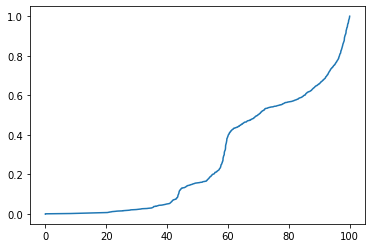

In [ ]:
lgbm_cpu_10 = train_lgbm(prepared, 10)
cdf(lgbm_cpu_10)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 3.96051
[100]	training's mape: 2664.45
[150]	training's mape: 466954
[200]	training's mape: 4.79175e+07
[250]	training's mape: 4.37579e+09
[300]	training's mape: 2.49982e+10
[350]	training's mape: 1.99471e+13
[400]	training's mape: 1.20109e+17
[450]	training's mape: 1.97081e+19
[500]	training's mape: 6.96656e+20
[550]	training's mape: 6.69948e+21
[600]	training's mape: 9.95932e+24
Early stopping, best iteration is:
[5]	training's mape: 0.0813846


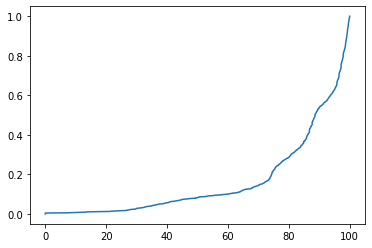

In [ ]:
lgbm_cpu_50 = train_lgbm(prepared, 50)
cdf(lgbm_cpu_50)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 0.189979
[100]	training's mape: 0.465637
[150]	training's mape: 0.911591
[200]	training's mape: 107973
[250]	training's mape: 1.79095e+06
[300]	training's mape: 4.65856e+06
[350]	training's mape: 1.34333e+08
[400]	training's mape: 2.22917e+09
[450]	training's mape: 6.5345e+10
[500]	training's mape: 1.29525e+11
[550]	training's mape: 9.69055e+11
[600]	training's mape: 1.25342e+12
Early stopping, best iteration is:
[5]	training's mape: 0.107348


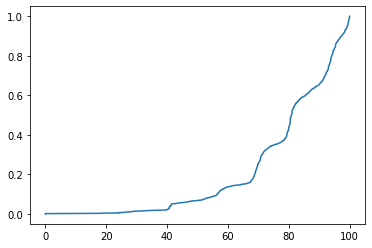

In [ ]:
lgbm_cpu_1 = train_lgbm(prepared, 1)
cdf(lgbm_cpu_1)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 0.00128676
[100]	training's mape: 0.00116076
[150]	training's mape: 0.00109072
[200]	training's mape: 0.00105799
[250]	training's mape: 0.00103082
[300]	training's mape: 0.00100646
[350]	training's mape: 0.000984277
[400]	training's mape: 0.000968154
[450]	training's mape: 0.000953043
[500]	training's mape: 0.000939473
[550]	training's mape: 0.000931384
[600]	training's mape: 0.000921577
[650]	training's mape: 0.000913636
[700]	training's mape: 0.000907921
[750]	training's mape: 0.000899904
[800]	training's mape: 0.000894685
Did not meet early stopping. Best iteration is:
[800]	training's mape: 0.000894685


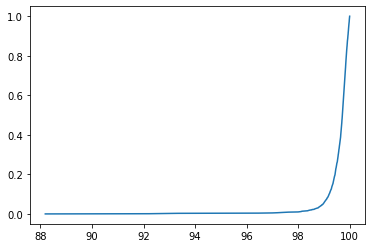

In [ ]:
lgbm_mem_10 = train_lgbm(prepared, 10)
cdf(lgbm_mem_10)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 0.00117948
[100]	training's mape: 0.0010411
[150]	training's mape: 0.000977928
[200]	training's mape: 0.0009348
[250]	training's mape: 0.000907293
[300]	training's mape: 0.000889429
[350]	training's mape: 0.000874424
[400]	training's mape: 0.000862514
[450]	training's mape: 0.000855266
[500]	training's mape: 0.000846043
[550]	training's mape: 0.000838731
[600]	training's mape: 0.000828696
[650]	training's mape: 0.000820817
[700]	training's mape: 0.000814096
[750]	training's mape: 0.000809305
[800]	training's mape: 0.000805222
Did not meet early stopping. Best iteration is:
[800]	training's mape: 0.000805222


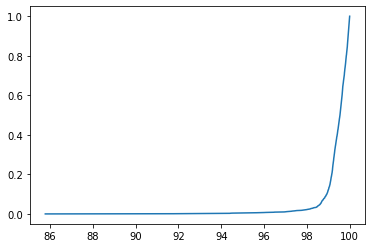

In [ ]:
lgbm_mem_50 = train_lgbm(prepared, 50)
cdf(lgbm_mem_50)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 0.00190944
[100]	training's mape: 0.0018509
[150]	training's mape: 0.00181895
[200]	training's mape: 0.00179637
[250]	training's mape: 0.00178089
[300]	training's mape: 0.00176903
[350]	training's mape: 0.00175793
[400]	training's mape: 0.00174835
[450]	training's mape: 0.00174014
[500]	training's mape: 0.00173023
[550]	training's mape: 0.00173191
[600]	training's mape: 0.00171937
[650]	training's mape: 0.00171108
[700]	training's mape: 0.00170518
[750]	training's mape: 0.00169999
[800]	training's mape: 0.00169285
Did not meet early stopping. Best iteration is:
[800]	training's mape: 0.00169285


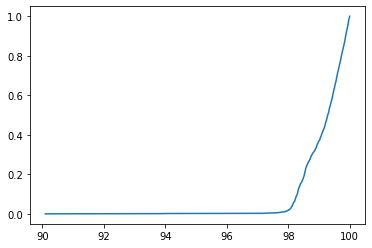

In [ ]:
lgbm_mem_1 = train_lgbm(prepared, 1)
cdf(lgbm_mem_1)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 111522
[100]	training's mape: 7.09314e+10
[150]	training's mape: 4.81774e+17
[200]	training's mape: 3.01255e+26
[250]	training's mape: 8.52979e+32
[300]	training's mape: 6.03904e+36
[350]	training's mape: 5.05686e+41
[400]	training's mape: 5.33725e+48
[450]	training's mape: 5.94068e+54
[500]	training's mape: 1.82837e+62
[550]	training's mape: 9.56634e+68
[600]	training's mape: 4.327e+73
Early stopping, best iteration is:
[9]	training's mape: 0.36517


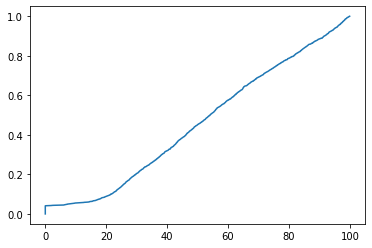

In [ ]:
lgbm_gpu_10 = train_lgbm(prepared, 10)
cdf(lgbm_gpu_10)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 27.3685
[100]	training's mape: 366893
[150]	training's mape: 5.60165e+07
[200]	training's mape: 1.10126e+12
[250]	training's mape: 3.61342e+14
[300]	training's mape: 2.37761e+19
[350]	training's mape: 1.23581e+22
[400]	training's mape: 2.4783e+25
[450]	training's mape: 1.5829e+29
[500]	training's mape: 8.25262e+34
[550]	training's mape: 7.58355e+37
[600]	training's mape: 8.49992e+39
Early stopping, best iteration is:
[6]	training's mape: 0.367394


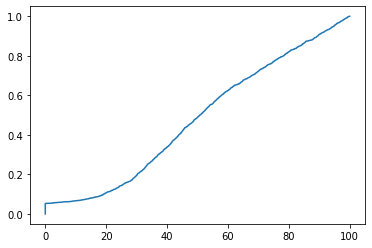

In [ ]:
lgbm_gpu_50 = train_lgbm(prepared, 50)
cdf(lgbm_gpu_50)

Training until validation scores don't improve for 600 rounds.
[50]	training's mape: 2.79138e+09
[100]	training's mape: 1.6855e+15
[150]	training's mape: 1.20253e+32
[200]	training's mape: 5.96148e+41
[250]	training's mape: 6.00105e+47
[300]	training's mape: 9.06354e+49
[350]	training's mape: 1.25617e+57
[400]	training's mape: 7.54431e+62
[450]	training's mape: 3.32907e+67
[500]	training's mape: 1.31406e+72
[550]	training's mape: 3.07733e+77
[600]	training's mape: 3.23915e+83
Early stopping, best iteration is:
[5]	training's mape: 0.423806


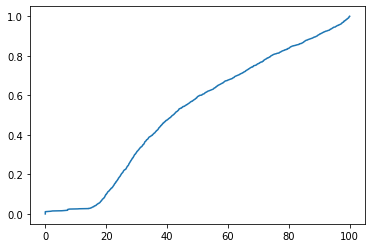

In [ ]:
lgbm_gpu_1 = train_lgbm(prepared, 1)
cdf(lgbm_gpu_1)

# **BRR**

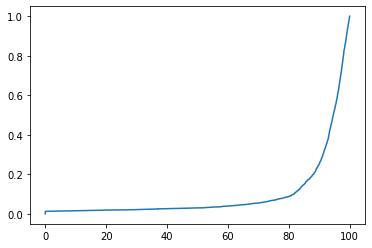

In [ ]:
brr_cpu_10 = train_brr(prepared, 10)
cdf(brr_cpu_10)

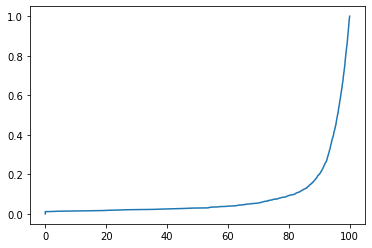

In [ ]:
brr_cpu_50 = train_brr(prepared, 50)
cdf(brr_cpu_50)

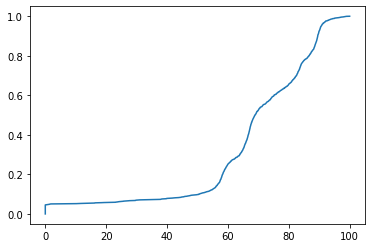

In [ ]:
brr_cpu_1 = train_brr(prepared, 1)
cdf(brr_cpu_1)

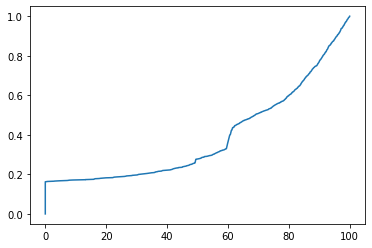

In [ ]:
brr_gpu_10 = train_brr(prepared, 10)
cdf(brr_gpu_10)

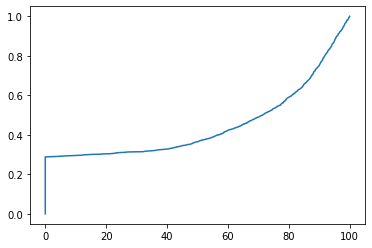

In [ ]:
brr_gpu_50 = train_brr(prepared, 50)
cdf(brr_gpu_50)

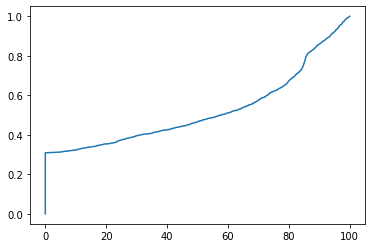

In [ ]:
brr_gpu_1 = train_brr(prepared, 1)
cdf(brr_gpu_1)

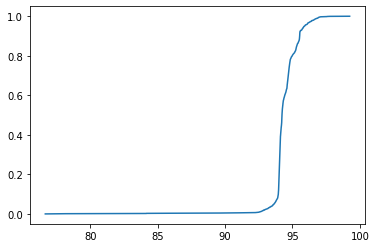

In [ ]:
brr_mem_10 = train_brr(prepared, 10)
cdf(brr_mem_10)

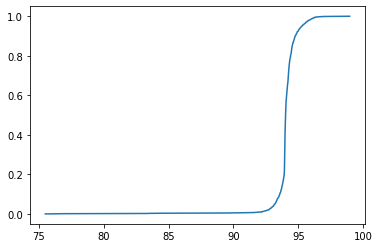

In [ ]:
brr_mem_50 = train_brr(prepared, 50)
cdf(brr_mem_50)

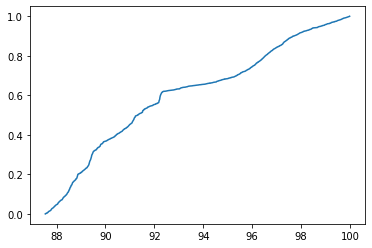

In [ ]:
brr_mem_1 = train_brr(prepared, 1)
cdf(brr_mem_1)

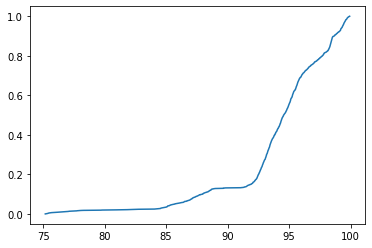

In [ ]:
brr_mem_10 = train_brr(prepared, 10)
cdf(brr_mem_10)

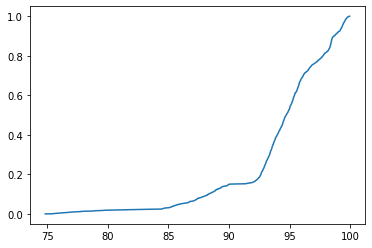

In [ ]:
brr_mem_50 = train_brr(prepared, 50)
cdf(brr_mem_50)

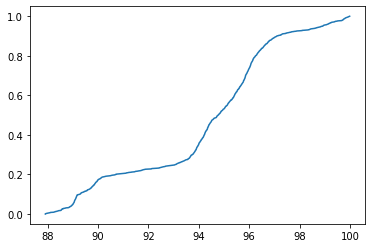

In [ ]:
brr_mem_1 = train_brr(prepared, 1)
cdf(brr_mem_1)

# **SVR**

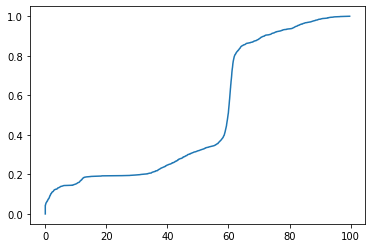

In [ ]:
svr_cpu_10 = train_svr(prepared, 10)
cdf(svr_cpu_10)

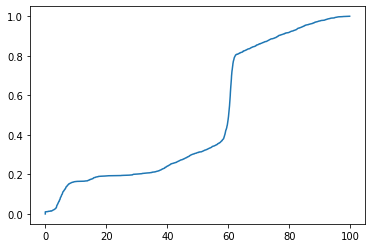

In [ ]:
svr_cpu_50 = train_svr(prepared, 50)
cdf(svr_cpu_50)

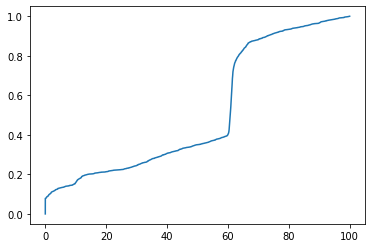

In [ ]:
svr_cpu_1 = train_svr(prepared, 1)
cdf(svr_cpu_1)

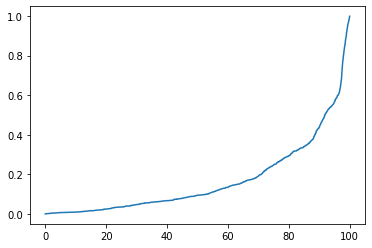

In [ ]:
svr_gpu_10 = train_svr(prepared, 10)
cdf(svr_gpu_10)

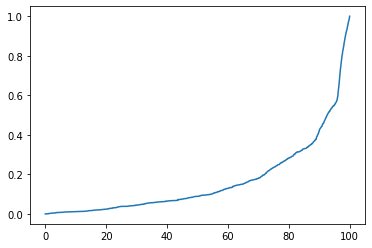

In [ ]:
svr_gpu_50 = train_svr(prepared, 50)
cdf(svr_gpu_50)

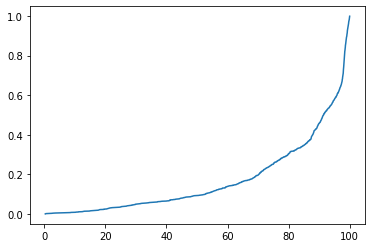

In [ ]:
svr_gpu_1 = train_svr(prepared, 1)
cdf(svr_gpu_1)

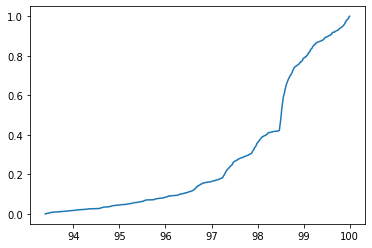

In [ ]:
svr_mem_10 = train_svr(prepared, 10)
cdf(svr_mem_10)

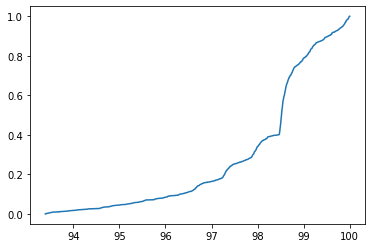

In [ ]:
svr_mem_50 = train_svr(prepared, 50)
cdf(svr_mem_50)

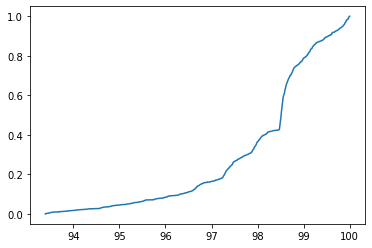

In [ ]:
svr_mem_1 = train_svr(prepared, 1)
cdf(svr_mem_1)

In [ ]:
train_set = group[0: TRAIN_SAMPLE_SIZE]
test_set = group[TRAIN_SAMPLE_SIZE: TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE]

In [ ]:
regressor = SVR(kernel = 'rbf')
regressor.fit(np.array(train_set['Time_Stamp']).reshape(-1, 1), np.array(train_set['value']))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
preds = regressor.predict(np.array(test_set['Time_Stamp']).reshape(-1, 1))

In [ ]:
preds

array([45.32501516, 45.32547672, 45.3259374 , ..., 44.90857761,
       44.90857775, 44.90857788])

In [ ]:
svr = accuracy(np.array(test_set['value']), preds)
svr

array([70.85357191, 60.45916028, 57.53391498, ...,  0.        ,
       63.88795721, 46.86170014])

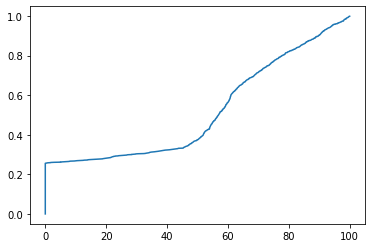

In [ ]:
cdf(svr)

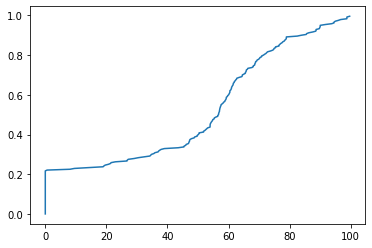

In [ ]:
svr_50 = accuracy(np.array(test_set['value']), preds)
cdf(svr_50)

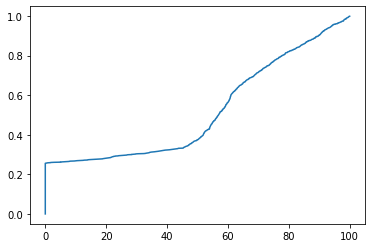

In [ ]:
svr_1 = accuracy(np.array(test_set['value']), preds)
cdf(svr)

# **Graphs**

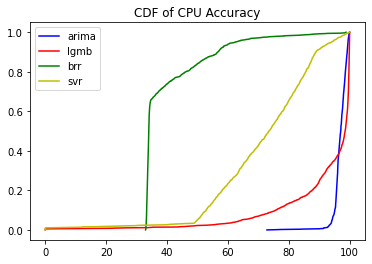

In [ ]:
# *****
y = np.arange(len(arima_cpu_10)) / len(arima_cpu_10)

plt.plot(sorted(arima_cpu_10), y, label='arima', color='b')
plt.plot(sorted(lgbm_cpu_10), y, label='lgmb', color='r')
plt.plot(sorted(brr_cpu_10), y, label='brr', color='g')
plt.plot(sorted(svr_cpu_10), y, label='svr', color='y')
plt.legend()

#plt.axis([80,100,0.0,1.0])
plt.title('CDF of CPU Accuracy')
plt.show()

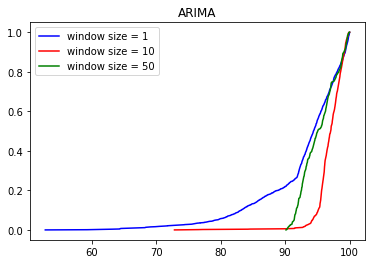

In [ ]:
# ****

plt.plot(sorted(arima_cpu_1), np.arange(len(arima_cpu_1)) / len(arima_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_cpu_10), np.arange(len(arima_cpu_10)) / len(arima_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_cpu_50), np.arange(len(arima_cpu_50)) / len(arima_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA')
plt.show()

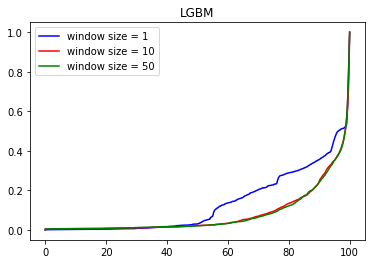

In [ ]:
# ****

plt.plot(sorted(lgbm_cpu_1), np.arange(len(lgbm_cpu_1)) / len(lgbm_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm_cpu_10), np.arange(len(lgbm_cpu_10)) / len(lgbm_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(lgbm_cpu_50), np.arange(len(lgbm_cpu_50)) / len(lgbm_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('LGBM')
plt.show()

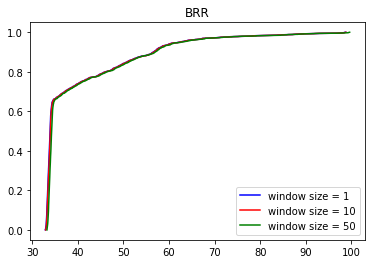

In [ ]:
# ****

plt.plot(sorted(brr_cpu_1), np.arange(len(brr_cpu_1)) / len(brr_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_cpu_10), np.arange(len(brr_cpu_10)) / len(brr_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_cpu_50), np.arange(len(brr_cpu_50)) / len(brr_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR')
plt.show()

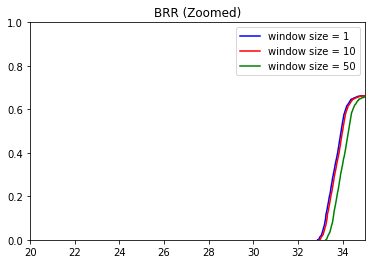

In [ ]:
# ****

plt.plot(sorted(brr_cpu_1), np.arange(len(brr_cpu_1)) / len(brr_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_cpu_10), np.arange(len(brr_cpu_10)) / len(brr_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_cpu_50), np.arange(len(brr_cpu_50)) / len(brr_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.axis([20,35,0.0,1.0])
plt.title('BRR (Zoomed)')
plt.show()

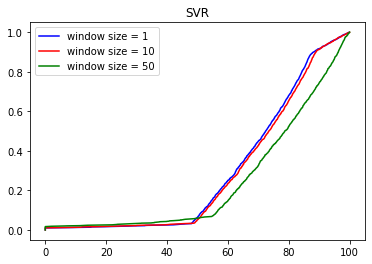

In [ ]:
# ****

plt.plot(sorted(svr_cpu_1), np.arange(len(svr_cpu_1)) / len(svr_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(svr_cpu_10), np.arange(len(svr_cpu_10)) / len(svr_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(svr_cpu_50), np.arange(len(svr_cpu_50)) / len(svr_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('SVR')
plt.show()

# **Graphs (Memory)**

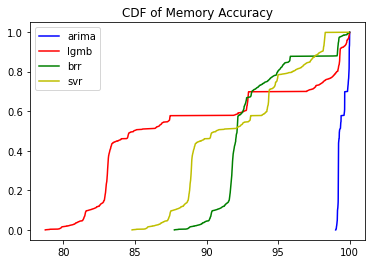

In [ ]:
# *****
y = np.arange(len(arima)) / len(arima)

plt.plot(sorted(arima), y, label='arima', color='b')
plt.plot(sorted(lgbm), y, label='lgmb', color='r')
plt.plot(sorted(brr), y, label='brr', color='g')
plt.plot(sorted(svr), y, label='svr', color='y')
plt.legend()
plt.title('CDF of Memory Accuracy')
plt.show()

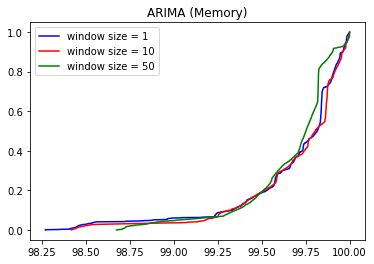

In [ ]:
# ****

plt.plot(sorted(arima_mem_1), np.arange(len(arima_mem_1)) / len(arima_mem_1), label='window size = 1', color='b')
plt.plot(sorted(arima_mem_10), np.arange(len(arima_mem_10)) / len(arima_mem_10), label='window size = 10', color='r')
plt.plot(sorted(arima_mem_50), np.arange(len(arima_mem_50)) / len(arima_mem_50), label='window size = 50', color='g')

plt.legend()
# plt.legend([99.98, 100, 0, 1])
plt.title('ARIMA (Memory)')
plt.show()

In [ ]:
# ****

plt.plot(sorted(arima_mem_1), np.arange(len(arima_mem_1)) / len(arima_mem_1), label='window size = 1', color='b')
plt.plot(sorted(arima_mem_10), np.arange(len(arima_mem_10)) / len(arima_mem_10), label='window size = 10', color='r')
plt.plot(sorted(arima_mem_50), np.arange(len(arima_mem_50)) / len(arima_mem_50), label='window size = 50', color='g')

plt.axis()
plt.legend()
plt.title('ARIMA (Memory)')
plt.show()

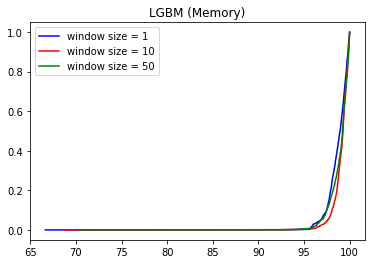

In [ ]:
# ****

plt.plot(sorted(lgbm_mem_1), np.arange(len(lgbm_mem_1)) / len(lgbm_mem_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm_mem_10), np.arange(len(lgbm_mem_10)) / len(lgbm_mem_10), label='window size = 10', color='r')
plt.plot(sorted(lgbm_mem_50), np.arange(len(lgbm_mem_50)) / len(lgbm_mem_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([99.8, 100, 0, 1])
plt.title('LGBM (Memory)')
plt.show()

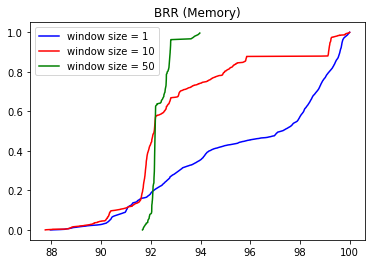

In [ ]:
# ****

plt.plot(sorted(brr_1), np.arange(len(brr_1)) / len(brr_1), label='window size = 1', color='b')
plt.plot(sorted(brr), np.arange(len(brr)) / len(brr), label='window size = 10', color='r')
plt.plot(sorted(brr_50), np.arange(len(brr_50)) / len(brr_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR (Memory)')
plt.show()

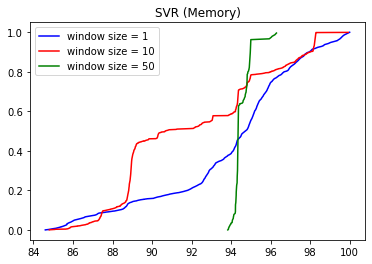

In [ ]:
# ****

plt.plot(sorted(svr_1), np.arange(len(svr_1)) / len(svr_1), label='window size = 1', color='b')
plt.plot(sorted(svr), np.arange(len(svr)) / len(svr), label='window size = 10', color='r')
plt.plot(sorted(svr_50), np.arange(len(svr_50)) / len(svr_50), label='window size = 50', color='g')

plt.legend()
plt.title('SVR (Memory)')
plt.show()

# **Graphs (Average GPU)**

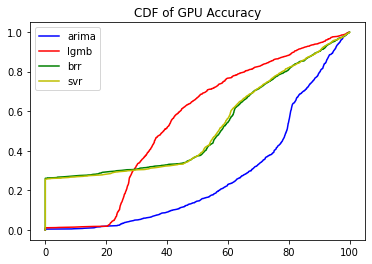

In [ ]:
# *****
y = np.arange(len(arima)) / len(arima)

plt.plot(sorted(arima), y, label='arima', color='b')
plt.plot(sorted(lgbm), y, label='lgmb', color='r')
plt.plot(sorted(brr), y, label='brr', color='g')
plt.plot(sorted(svr), y, label='svr', color='y')
plt.legend()
plt.title('CDF of GPU Accuracy')
plt.show()

In [ ]:
# ****

plt.plot(sorted(arima_1), np.arange(len(arima_1)) / len(arima_1), label='window size = 1', color='b')
plt.plot(sorted(arima), np.arange(len(arima)) / len(arima), label='window size = 10', color='r')
plt.plot(sorted(arima_50), np.arange(len(arima_50)) / len(arima_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA (GPU)')
plt.show()

NameError: ignored

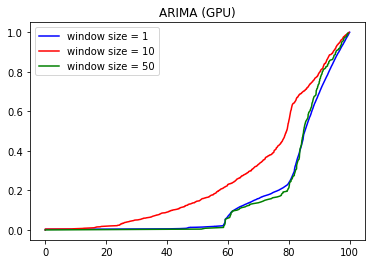

In [ ]:
# ****

plt.plot(sorted(arima_1), np.arange(len(arima_1)) / len(arima_1), label='window size = 1', color='b')
plt.plot(sorted(arima), np.arange(len(arima)) / len(arima), label='window size = 10', color='r')
plt.plot(sorted(arima_50), np.arange(len(arima_50)) / len(arima_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA (GPU)')
plt.show()

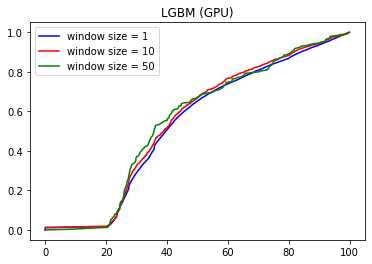

In [ ]:
# ****

plt.plot(sorted(lgbm_1), np.arange(len(lgbm_1)) / len(lgbm_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm), np.arange(len(lgbm)) / len(lgbm), label='window size = 10', color='r')
plt.plot(sorted(lgbm_50), np.arange(len(lgbm_50)) / len(lgbm_50), label='window size = 50', color='g')

plt.legend()
plt.title('LGBM (GPU)')
plt.show()

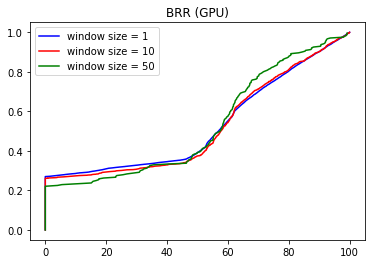

In [ ]:
# ****

plt.plot(sorted(brr_1), np.arange(len(brr_1)) / len(brr_1), label='window size = 1', color='b')
plt.plot(sorted(brr), np.arange(len(brr)) / len(brr), label='window size = 10', color='r')
plt.plot(sorted(brr_50), np.arange(len(brr_50)) / len(brr_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR (GPU)')
plt.show()

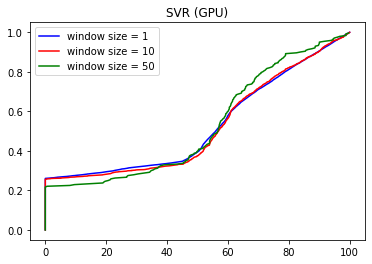

In [ ]:
# ****

plt.plot(sorted(svr_1), np.arange(len(svr_1)) / len(svr_1), label='window size = 1', color='b')
plt.plot(sorted(svr), np.arange(len(svr)) / len(svr), label='window size = 10', color='r')
plt.plot(sorted(svr_50), np.arange(len(svr_50)) / len(svr_50), label='window size = 50', color='g')

plt.legend()
plt.title('SVR (GPU)')
plt.show()

# **Comprehensive Graphs**

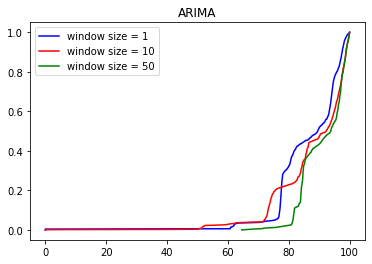

In [ ]:
plt.plot(sorted(arima_cpu_1), np.arange(len(arima_cpu_1)) / len(arima_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_cpu_10), np.arange(len(arima_cpu_10)) / len(arima_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_cpu_50), np.arange(len(arima_cpu_50)) / len(arima_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA')
plt.show()

In [ ]:
plt.plot(sorted(lgbm_cpu_1), np.arange(len(lgbm_cpu_1)) / len(lgbm_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm_cpu_10), np.arange(len(lgbm_cpu_10)) / len(lgbm_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(lgbm_cpu_50), np.arange(len(lgbm_cpu_50)) / len(lgbm_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('LGBM')
plt.show()

NameError: ignored

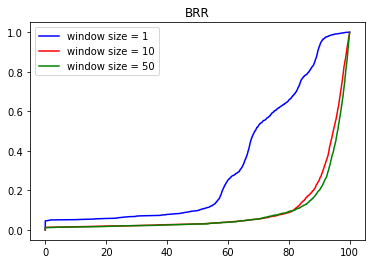

In [ ]:
plt.plot(sorted(brr_cpu_1), np.arange(len(brr_cpu_1)) / len(brr_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_cpu_10), np.arange(len(brr_cpu_10)) / len(brr_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_cpu_50), np.arange(len(brr_cpu_50)) / len(brr_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR')
plt.show()

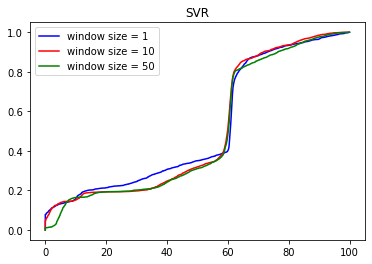

In [ ]:

plt.plot(sorted(svr_cpu_1), np.arange(len(svr_cpu_1)) / len(svr_cpu_1), label='window size = 1', color='b')
plt.plot(sorted(svr_cpu_10), np.arange(len(svr_cpu_10)) / len(svr_cpu_10), label='window size = 10', color='r')
plt.plot(sorted(svr_cpu_50), np.arange(len(svr_cpu_50)) / len(svr_cpu_50), label='window size = 50', color='g')

plt.legend()
plt.title('SVR')
plt.show()

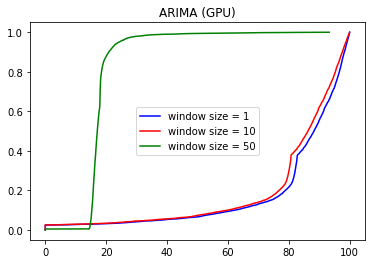

In [ ]:
plt.plot(sorted(arima_gpu_1), np.arange(len(arima_gpu_1)) / len(arima_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_gpu_10), np.arange(len(arima_gpu_10)) / len(arima_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_gpu_50), np.arange(len(arima_gpu_50)) / len(arima_gpu_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([80,100,0,1])
plt.title('ARIMA (GPU)')
plt.show()

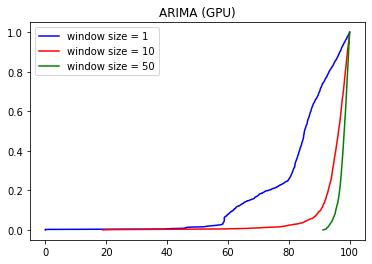

In [ ]:
plt.plot(sorted(arima_gpu_1), np.arange(len(arima_gpu_1)) / len(arima_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(arima_gpu_10), np.arange(len(arima_gpu_10)) / len(arima_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(arima_gpu_50), np.arange(len(arima_gpu_50)) / len(arima_gpu_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([80,100,0,1])
plt.title('ARIMA (GPU)')
plt.show()

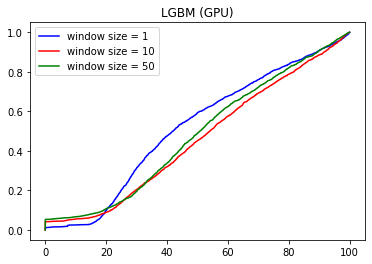

In [ ]:
plt.plot(sorted(lgbm_gpu_1), np.arange(len(lgbm_gpu_1)) / len(lgbm_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm_gpu_10), np.arange(len(lgbm_gpu_10)) / len(lgbm_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(lgbm_gpu_50), np.arange(len(lgbm_gpu_50)) / len(lgbm_gpu_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([80,100,0,1])
plt.title('LGBM (GPU)')
plt.show()

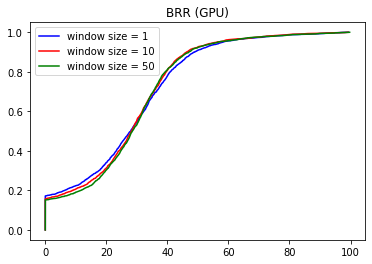

In [ ]:
plt.plot(sorted(brr_gpu_1), np.arange(len(brr_gpu_1)) / len(brr_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_gpu_10), np.arange(len(brr_gpu_10)) / len(brr_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_gpu_50), np.arange(len(brr_gpu_50)) / len(brr_gpu_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([10,40,0,1])
plt.title('BRR (GPU)')
plt.show()

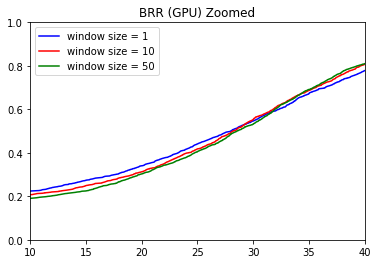

In [ ]:
plt.plot(sorted(brr_gpu_1), np.arange(len(brr_gpu_1)) / len(brr_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_gpu_10), np.arange(len(brr_gpu_10)) / len(brr_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_gpu_50), np.arange(len(brr_gpu_50)) / len(brr_gpu_50), label='window size = 50', color='g')

plt.legend()
plt.axis([10,40,0,1])
plt.title('BRR (GPU) Zoomed')
plt.show()

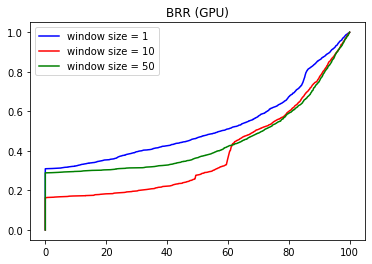

In [ ]:
plt.plot(sorted(brr_gpu_1), np.arange(len(brr_gpu_1)) / len(brr_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(brr_gpu_10), np.arange(len(brr_gpu_10)) / len(brr_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(brr_gpu_50), np.arange(len(brr_gpu_50)) / len(brr_gpu_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([10,40,0,1])
plt.title('BRR (GPU)')
plt.show()

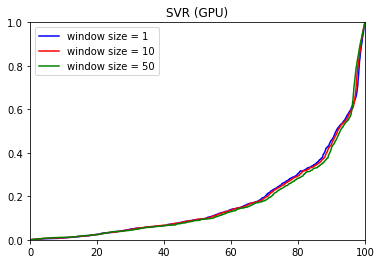

In [ ]:
plt.plot(sorted(svr_gpu_1), np.arange(len(svr_gpu_1)) / len(svr_gpu_1), label='window size = 1', color='b')
plt.plot(sorted(svr_gpu_10), np.arange(len(svr_gpu_10)) / len(svr_gpu_10), label='window size = 10', color='r')
plt.plot(sorted(svr_gpu_50), np.arange(len(svr_gpu_50)) / len(svr_gpu_50), label='window size = 50', color='g')

plt.legend()
plt.axis([0,100,0,1])
plt.title('SVR (GPU)')
plt.show()

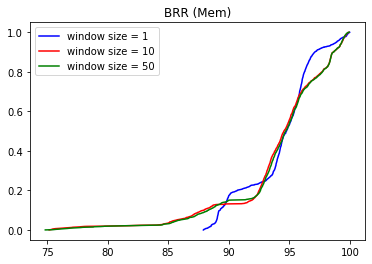

In [ ]:
plt.plot(sorted(brr_mem_1), np.arange(len(brr_mem_1)) / len(brr_mem_1), label='window size = 1', color='b')
plt.plot(sorted(brr_mem_10), np.arange(len(brr_mem_10)) / len(brr_mem_10), label='window size = 10', color='r')
plt.plot(sorted(brr_mem_50), np.arange(len(brr_mem_50)) / len(brr_mem_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([10,40,0,1])
plt.title('BRR (Mem)')
plt.show()

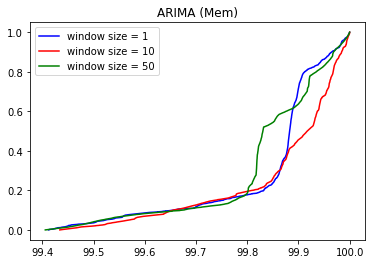

In [ ]:
plt.plot(sorted(arima_mem_1), np.arange(len(arima_mem_1)) / len(arima_mem_1), label='window size = 1', color='b')
plt.plot(sorted(arima_mem_10), np.arange(len(arima_mem_10)) / len(arima_mem_10), label='window size = 10', color='r')
plt.plot(sorted(arima_mem_50), np.arange(len(arima_mem_50)) / len(arima_mem_50), label='window size = 50', color='g')

plt.legend()
plt.title('ARIMA (Mem)')
plt.show()

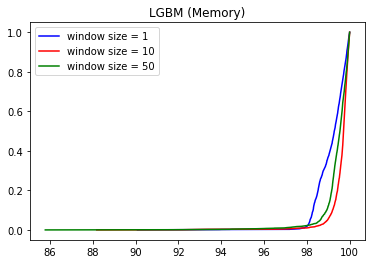

In [ ]:
plt.plot(sorted(lgbm_mem_1), np.arange(len(lgbm_mem_1)) / len(arima_mem_1), label='window size = 1', color='b')
plt.plot(sorted(lgbm_mem_10), np.arange(len(lgbm_mem_10)) / len(arima_mem_10), label='window size = 10', color='r')
plt.plot(sorted(lgbm_mem_50), np.arange(len(lgbm_mem_50)) / len(arima_mem_50), label='window size = 50', color='g')

plt.legend()
plt.title('LGBM (Memory)')
plt.show()

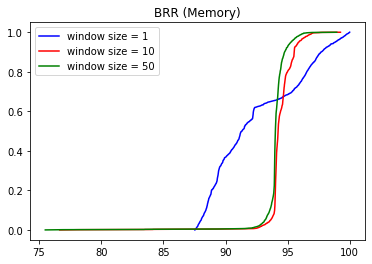

In [ ]:
plt.plot(sorted(brr_mem_1), np.arange(len(brr_mem_1)) / len(brr_mem_1), label='window size = 1', color='b')
plt.plot(sorted(brr_mem_10), np.arange(len(brr_mem_10)) / len(brr_mem_10), label='window size = 10', color='r')
plt.plot(sorted(brr_mem_50), np.arange(len(brr_mem_50)) / len(brr_mem_50), label='window size = 50', color='g')

plt.legend()
plt.title('BRR (Memory)')
plt.show()

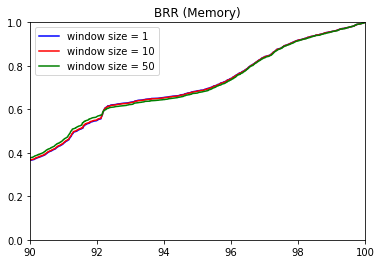

In [ ]:
plt.plot(sorted(svr_mem_1), np.arange(len(svr_mem_1)) / len(svr_mem_1), label='window size = 1', color='b')
plt.plot(sorted(svr_mem_10), np.arange(len(svr_mem_10)) / len(svr_mem_10), label='window size = 10', color='r')
plt.plot(sorted(svr_mem_50), np.arange(len(svr_mem_50)) / len(svr_mem_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([90,100,0,1])
plt.title('SV (Memory)')
plt.show()

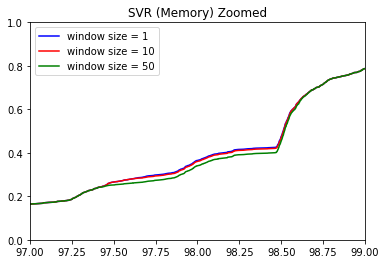

In [ ]:
plt.plot(sorted(svr_mem_1), np.arange(len(svr_mem_1)) / len(svr_mem_1), label='window size = 1', color='b')
plt.plot(sorted(svr_mem_10), np.arange(len(svr_mem_10)) / len(svr_mem_10), label='window size = 10', color='r')
plt.plot(sorted(svr_mem_50), np.arange(len(svr_mem_50)) / len(svr_mem_50), label='window size = 50', color='g')

plt.legend()
plt.axis([97,99,0,1])
plt.title('SVR (Memory) Zoomed')
plt.show()

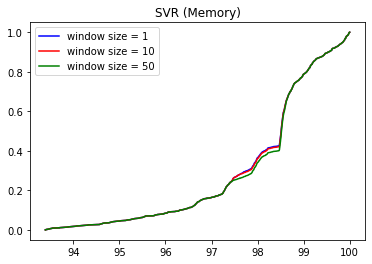

In [ ]:
plt.plot(sorted(svr_mem_1), np.arange(len(svr_mem_1)) / len(svr_mem_1), label='window size = 1', color='b')
plt.plot(sorted(svr_mem_10), np.arange(len(svr_mem_10)) / len(svr_mem_10), label='window size = 10', color='r')
plt.plot(sorted(svr_mem_50), np.arange(len(svr_mem_50)) / len(svr_mem_50), label='window size = 50', color='g')

plt.legend()
# plt.axis([70,98.9,0,1])
plt.title('SVR (Memory)')
plt.show()